# PyTorch Dataset Class

[Basics Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

[Medium Example](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

[Masks Example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

[In depth](https://blog.paperspace.com/dataloaders-abstractions-pytorch/)

From the basics dataset link above the dataset class must have three functions: __init__, __len__, and __getitem__.

__init__
The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The __len__ function returns the number of samples in our dataset.

__getitem__
The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a Python dict.
    
Let's build one for our dataset.

**NB** I created a dictionary of ID to Label, this will be different for our weak labelled data.

In [73]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision

# model imports
import copy

In [2]:
# Load data 
X = pd.read_csv('../input/image_subset/subset_train.csv')
X.Label = X['Label'].astype('int')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3511 non-null   object
 1   Label   3511 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 41.3+ KB


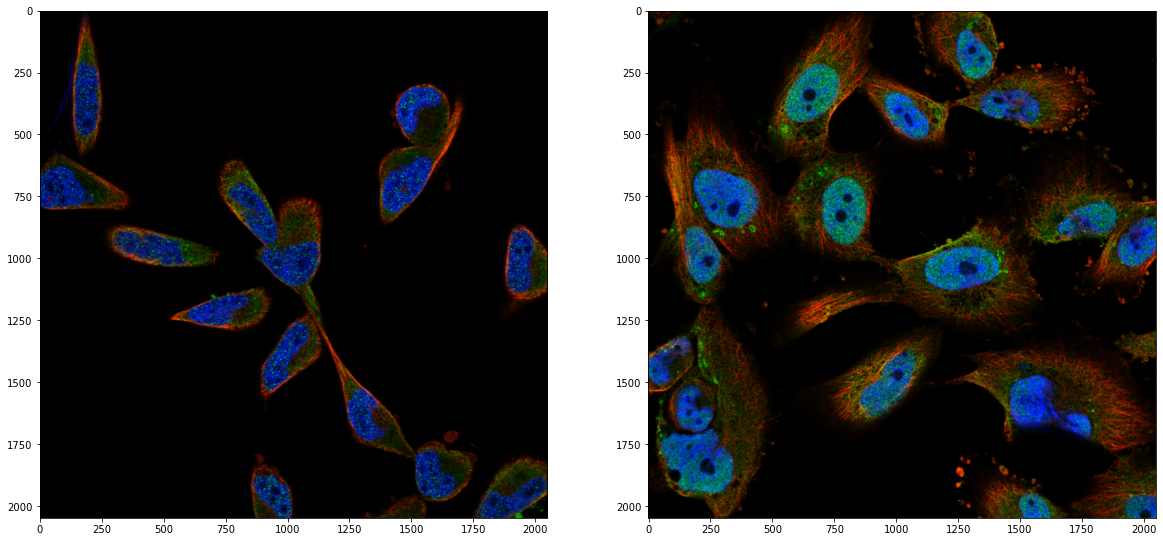

In [3]:
# view a couple RGBY-RGB converted images

SAVE_DIR = '../input/image_subset/image/'
rand = random.sample(sorted(X.ID), 2)
fig, ax = plt.subplots(1,2, figsize=(20,50))
ax[0].imshow(Image.open(SAVE_DIR+rand[0]+'.png'))
ax[1].imshow(Image.open(SAVE_DIR+rand[1]+'.png'))
plt.show()

## Transformers

[Custom Transformers Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

Most nueral networks expect the image to be fixed size. Therefore we will need to some preprocessing code.

Augmentation can also be included in this step. Randomly cropping or changing contrast etc can be useful to help the model generalize well. I will not include any augmentation in this notebook. Clink on the link for some examples of augmentation.

For our transormation we are going to rescale and transform into a tensor.

**NB I haven't included a Normalization transformer yet, I wasn't sure how to find the best mean and std. Maybe you have some thoughts? A second NB may be in order for the best transformers.**

<code>transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
</code>

**NB2 The color mask needs to be resized before it can be split, tensors are hard to resize. Therefore transformer should go rescale -> add bounding box/ area-> totensor(img)**


What we want to do is receive a full size image including the masks. Then split the image into tiles of the individual cells. After we have split into tiles we can then output several tiles per iamge, each with the same label. This can then be inputted into an multi-image classification problem. Thus splitting the instance segmentation problem into a image classification problem.

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        imgs, target = sample['image'], sample['target']

        for i in range(len(imgs)):
            w, h = imgs[i].size 

            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            #resize iamge
            imgs[i] = imgs[i].resize((new_h, new_w))
        return {'image': imgs, 'target': target}

    
class split_mask(object):
    """Takes in PIL image of original image and Mask.
        Tiles Image according to desired size
        Padding could be a good idea
    """
    def __init__(self, tile_size):
        assert isinstance(tile_size, (int))
        self.tile_size = tile_size
        
        
    def tiled_img(self, img, box):
        """
        Find center of box. Crop the image using PIL
        at center, using desired tile size.
        """
        # (xmax-xmin) / 2 , (ymax - ymin) /2
        center = ( (box[2]-box[0])/2, (box[3]-box[1])/2 )
        
#         # Setting the points for cropped image
#         left = int(center[0] - self.tile_size/2)
#         top = int(center[1] + self.tile_size/2)
#         right = left + self.tile_size
#         bottom = top + self.tile_size
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        # return crop using PIL 
        return(img.crop((left, top, right, bottom)))
        
        
    def __call__(self, sample):
        img, target = sample['image'], sample['target']
        
        # load target
        mask = target['masks']
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
         
        # list of tiled imgs
        tiles = list()
        for box in boxes:
            tiles.append(self.tiled_img(img, box))
             
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # define target
        imgs = tiles
        
        # convert to tensor
        target['labels'] = torch.as_tensor([target['labels'] 
                                           for i in range(num_objs)], dtype=torch.int64)
        
        return {'image': imgs, 'target': target}
    
    
class ImageToTensor(object):
    """Custom to tensor class, does not accept dictionary."""

    def __call__(self, sample):
        imgs, target = sample['image'], sample['target']
        # torch image: C X H X W
        for i in range(len(imgs)):
            imgs[i] = transforms.ToTensor()(imgs[i])
        return {'image': imgs, 'target': target}


Now let's build the dataset and loader with transformers and new RGB images.

In [7]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, labels):
        self.root = root
        self.transforms = transforms
        # sort in order to make sure they
        # are aligned
        self.labels = labels # dictionary {'ID': 'label'}
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'image'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'mask'))))
                          
                          
    def __len__(self):
        return(len(self.imgs))
                          
    
    def __getitem__(self, idx):
        # load images and masks for idx
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        # open img in PIL
        img = Image.open(img_path)
        # load mask
        mask = Image.open(mask_path)
        
        #define target
        target = {}
        # set image id and mask
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["masks"] = mask
        # label there is only one class in picture
        # this is how the dataset is defined
        label = self.labels[os.path.basename(img_path[:-4])]
        target["labels"] = label
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = self.transforms({'image': img, 'target': target})
            imgs, targets = sample['image'], sample['target']
        # choose what returning 
        imgs = imgs
        annotations = {
            'image_id': targets['image_id'],
            'labels': targets['labels']
        }
        return(imgs, annotations)  

## Dataloader

[Speeding up Dataloader stackoverflow](https://stackoverflow.com/questions/61393613/pytorch-speed-up-data-loading)

[Example Pytorch](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset)

In [24]:
# define labels as a dictionary
map_labels={
    0: 0,
    14: 1,
    16: 2
}

labels = dict(zip(X.ID, X.Label.apply(lambda x: map_labels[x])))

In [25]:
# define transforms
def get_transform():
    custom_transforms = [split_mask(224), Rescale((224,224)),
                        ImageToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

ROOT_DIR = '../input/image_subset/'
# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          labels=labels,
                          )

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

sub_dataset = torch.utils.data.Subset(transformed_dataset, list(range(100)))
data_loader = torch.utils.data.DataLoader(sub_dataset,
                                          batch_size=10,
                                          shuffle=False,
                                         collate_fn = collate_fn)

for i_batch, sample_batched in enumerate(data_loader):
    print(i_batch, len(sample_batched[0]))
    print(i_batch)
    
    # observe 4th batch and stop.
    if i_batch == 1:
        break 

0 10
0
1 10
1


In [27]:
len(sample_batched[0][0])

39

Output image tensor should be of form (batch, channels, height, width). - I have not got this as needed to include [collate_fn](https://discuss.pytorch.org/t/how-to-use-collate-fn/27181). I think the output of my dataloader is wrong.


**NB number of batch_size is number of items you want per batch from your dataset or number of rows. The data_loader takes care of the number of batches.**

The output is as follow:

sample_batched= (all_image_frames, all_dicts of id and labels)

within all_image_frames is a list of images:
<code>
[image1,image2...etc]
</code>
within each image are the tiles for each image.
<code>
[tile1,tile2..etc]
</code>
therfore to get an individual tile you need:
<code>
sample_batched[all_image_frames][image_n][tile_n]
</code>
or
<code>
sample_batched[0][image_n][tile_n]
</code>

with the corresponding label:
<code>
sample_batched[1][image_n]['labels'][tile_n]
</code>

In [28]:
# labels for image 0
sample_batched[1][0]

{'image_id': tensor([10]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [29]:
# number of images in batch
len(sample_batched[0])

10

In [30]:
# number of tiles in image 0
len(sample_batched[0][0])

39

torch.Size([3, 224, 224])
This tile has label: tensor(0)


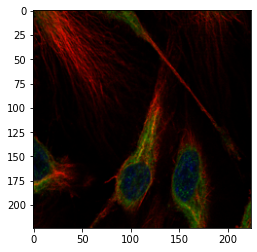

In [31]:
print(sample_batched[0][0][0].size())
plt.imshow(transforms.ToPILImage(mode='RGB')(sample_batched[0][0][0]))
print('This tile has label: '+str(sample_batched[1][0]['labels'][0]))

# Model

[Resnet50 Pytorch Kaggle](https://www.kaggle.com/gxkok21/resnet50-with-pytorch)

[Pytorch Resnet](https://pytorch.org/hub/pytorch_vision_resnet/)

Examples of training from kaggle:

- [Efficientnet](https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-training)

PyTorch example object detection:

- [Pytorch](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

One guy said we should look into:

- [Class Activation Map](https://www.kaggle.com/thedrcat/cam-class-activation-map-explained-in-pytorch)
- [Focal Loss](https://www.kaggle.com/thedrcat/focal-multilabel-loss-in-pytorch-explained)
- [Oversampling](https://www.kaggle.com/thedrcat/oversampling-for-multi-label-classification)

Kaggle thread on papers:
- [Papers](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214891)

Abishkek Thakur Tez:

[Tez](https://github.com/abhishekkrthakur/tez)
Tez wasn't working for me. It used torch.optim.lr_scheduler.save state which has been removed.


Let's have a look at splitting the dataset into train and test. Then see what sort of input the model needs for training.

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [33]:
# set train val split
split = int(0.8 * len(transformed_dataset))

# batch size
batch_s = 8

# train dataset & dataloader
dataset_train = torch.utils.data.Subset(transformed_dataset, 
                                        list(range(0,split)))

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_s,
                                          shuffle=True, collate_fn=collate_fn)

# test dataset & dataloader
dataset_test = torch.utils.data.Subset(transformed_dataset,
                                     list(range(split, len(transformed_dataset))))
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle=False, collate_fn=collate_fn)
print(len(dataset_train))
print(len(dataset_test))

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

2808
703


In [34]:
if len(train_loader) * batch_s == len(dataset_train):
    print('Setup is correct')

Setup is correct


In [35]:
len(train_loader)

351

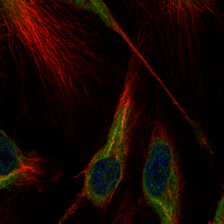

In [36]:
single_batch = next(iter(train_loader))

# sigle_batch[img or label][img_n][tile_n]
(transforms.ToPILImage(mode='RGB')(sample_batched[0][0][0]))

In [37]:
# model = torchvision.models.resnet50(pretrained=True)
model = torchvision.models.resnet50()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The resnet50 model above has an output of 1000 features. We however have 3 output labels: 0, 14 and 16. Therfore we will have 3 output features.

So let's change the final fully connected layer to suit the problem.

[Helpful medium](https://thevatsalsaglani.medium.com/multi-class-image-classification-using-cnn-over-pytorch-and-the-basics-of-cnn-fdf425a11dc0#4e3e)

I am a little bit unsure how to calculate in_features. If you can help let me know.

In [38]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
#out = model(transformed_dataset[0][0][0].view(1, 3, 224, 224))
#out.shape

## Model training

In [47]:
# Config
USE_GPU = True
EPOCHS = 1

In [91]:
# number of tiles in image
single_batch[0][0][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [110]:
# labels in image
single_batch[1][0]['labels'][0]

tensor(0)

In [117]:
arr = np.zeros(3)
arr[1] = 1
arr
torch.from_numpy(arr)

tensor([0., 1., 0.], dtype=torch.float64)

In [ ]:
if USE_GPU:
    model = model.cuda() # Should be called before instantiating optimizer according to docs: https://pytorch.org/docs/stable/nn.html

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for i in range(EPOCHS):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for j, batch in enumerate(dataloaders[phase]):
            # define images in batch 
            # sigle_batch[img or label][img_n][tile_n]
            
            imgs = batch[0]
            anno = batch[1]
            
            # get images in batch (we want individual tiles)
            for z in (range(len(imgs))):
                samples = 0
                loss_sum = 0
                correct_sum = 0
                
                for k in (range(len(imgs[z]))):
                    X = imgs[z][k] # choose tile
                    
                    def encode_label(label):
                        arr = np.zeros(3)
                        arr[label] = 1
                        return(torch.from_numpy(arr))
                        
                        
                    label = anno[z]["labels"][k] # choose tile label
                    labels = encode_label(label)
                    if USE_GPU:
                        X = X.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        y = model(X.unsqueeze(0)) # beacuase we aren't using batch properly
                        loss = criterion(
                            y.squeeze(), # because we didn't define labels properly
                            labels.float()
                        )

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                        loss_sum += loss.item() * 1 #X.shape[0] # We need to multiple by batch size as loss is the mean loss of the samples in the batch
                        samples += 1 #len(X) # how many tiles
                        num_corrects = torch.sum((y >= 0.5).float() == labels.float())
                        correct_sum += num_corrects

                        # Print image statistics every 50 batches
                        if j % 50 == 49 and phase == "train":
                            print("{}:{} - loss: {}, acc: {}".format(
                                i + 1, 
                                j + 1, 
                                float(loss_sum) / float(samples), 
                                float(correct_sum) / float(samples)
                            ))

    # Print epoch statistics
    epoch_acc = float(correct_sum) / float(samples)
    epoch_loss = float(loss_sum) / float(samples)
    print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))

    # Deep copy the model
    if phase == "test" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "resnet50.pth")

## Probelms So Far


- dataset does not produced one hot encoded label, we are doing that during the training phase.
    - beacuse of this our loss function may be calculating the wrong error in every fit.
- Our dataloader currently produces output of batch = imgs , labels = tiles, labels. We want batch = tiles, labels. I think the collate_fn fucntion can get that working.
    - because of this the model is training over a loop of tiles in images in a batch. Therefore our loss function is going to be off.
    
Look into sampler and collate_fn in DataLoader to try and get a tiles, labels output per batch. 

[PyTorch datasheet](https://pytorch.org/docs/stable/data.html)

To do:

- try and implement [resnet50](https://www.kaggle.com/gxkok21/resnet50-with-pytorch) with custom datasetloader. Should be a for loop in a for loop in training. May have some problems with gpu memory allocation as each image has an unknown number of objets within.

- mask images properly, not bounding boxes but with masks and zero padding.